# Import modules and Preporcessing

In [159]:
import pandas as pd
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Load images

In [160]:
dataset_root_folder = './flowers'

x_image = []
y_label = []
img_size = (150, 150)

# get a list of all folders inside "flowers" directory
labels = os.listdir(dataset_root_folder)

# get all images in all subfolders
for dirname in labels:
	filepath = os.path.join(dataset_root_folder, dirname)
	for file in os.listdir(filepath):
		filename = os.path.join(filepath, file)
		# load image
		image = cv2.imread(filename)
		image = cv2.resize(image, img_size)
		x_image.append(image)
		y_label.append(dirname)

### Extract color histogram features

In [161]:
def extract_color_histogram(images, bins=[6, 6, 6]):
    ls_hist = []

    for img in x_image:
        hist = cv2.calcHist([img], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
        cv2.normalize(hist, hist)
        hist = hist.flatten()
        ls_hist.append(hist)
    return ls_hist

x_hist = extract_color_histogram(x_image)

### Split dataset into training, validation, and test

In [162]:
seed = 321

# To keep track of shuffled data and their indices to refer to the image
indexes_for_split = [x for x in range(len(x_hist))]
_, test_label_indexes, ___, ____ = train_test_split(indexes_for_split, y_label, test_size=0.2, random_state=seed, shuffle=True, stratify=y_label)

# Actual train test split of data
x_train_val, x_test, y_train_val, y_test = train_test_split(x_hist, y_label, test_size=0.2, random_state=seed, shuffle=True, stratify=y_label)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=seed, shuffle=True, stratify=y_train_val)

# MLP

In [163]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sn
import time

In [164]:
input_size = x_train[0].shape
input_size = input_size[0]
input_size

216

Create various NLPs

In [174]:
ls_mlps = []
seed = 21                   # seed for random_state
hidden_layers = [1, 2, 3]   # number of hidden layers
output_shape = 5            # Five flowers
neurons_count = [
    int(input_size / 2),
    int(input_size * (2/3)),
    input_size * 2 - 1
]

layers_and_neurons = []     # list of tuples containing the information of the number of hidden layers and neurons for each mlp model

# Create the models from various layer sizes and neuron counts
for layers in hidden_layers:
    for neurons in neurons_count:
        hidden_layer_sizes = [neurons for _ in range(layers)]
        layers_and_neurons.append(hidden_layer_sizes)
        ls_mlps.append(
            MLPClassifier(
                random_state=seed, 
                hidden_layer_sizes = hidden_layer_sizes,
                # validation_fraction = 0.25,
                early_stopping=True,
                verbose=True
            )
        )

Train the neural network models

In [175]:
training_durations = []
for mlp in ls_mlps:
    start_time = time.time()
    mlp.fit(x_train, y_train)
    duration = time.time() - start_time
    training_durations.append(duration)

Iteration 1, loss = 1.59189343
Validation score: 0.250965
Iteration 2, loss = 1.55694240
Validation score: 0.270270
Iteration 3, loss = 1.52038834
Validation score: 0.332046
Iteration 4, loss = 1.48031685
Validation score: 0.370656
Iteration 5, loss = 1.43397397
Validation score: 0.401544
Iteration 6, loss = 1.38509125
Validation score: 0.436293
Iteration 7, loss = 1.33963449
Validation score: 0.436293
Iteration 8, loss = 1.29779342
Validation score: 0.467181
Iteration 9, loss = 1.26243668
Validation score: 0.474903
Iteration 10, loss = 1.23234070
Validation score: 0.486486
Iteration 11, loss = 1.20760107
Validation score: 0.501931
Iteration 12, loss = 1.18704017
Validation score: 0.517375
Iteration 13, loss = 1.16958625
Validation score: 0.513514
Iteration 14, loss = 1.15410885
Validation score: 0.521236
Iteration 15, loss = 1.14106396
Validation score: 0.528958
Iteration 16, loss = 1.12888978
Validation score: 0.548263
Iteration 17, loss = 1.11751662
Validation score: 0.548263
Iterat

Graph accuracy of each models

In [176]:
accuracies = []
for i, mlp in enumerate(ls_mlps):
    # Get accuracy of model on test set and record it
    accuracy = mlp.score(x_val, y_val)
    accuracies.append(accuracy)

    # Get the number of layers and neurons information for the current model
    layer_neurons_info = list(layers_and_neurons[i])

    # Output information
    print(f"MLP model w/ {len(layer_neurons_info)} hidden layers and {layer_neurons_info[0]} neurons")
    print("accuracy on validation dataset =", accuracy)
    print("Training duration: ", training_durations[i])
    print("-" * 40)

MLP model w/ 1 hidden layers and 108 neurons
accuracy on validation dataset = 0.5694444444444444
Training duration:  1.7205069065093994
----------------------------------------
MLP model w/ 1 hidden layers and 144 neurons
accuracy on validation dataset = 0.5833333333333334
Training duration:  3.244509220123291
----------------------------------------
MLP model w/ 1 hidden layers and 431 neurons
accuracy on validation dataset = 0.5972222222222222
Training duration:  4.071511268615723
----------------------------------------
MLP model w/ 2 hidden layers and 108 neurons
accuracy on validation dataset = 0.6122685185185185
Training duration:  3.439999580383301
----------------------------------------
MLP model w/ 2 hidden layers and 144 neurons
accuracy on validation dataset = 0.59375
Training duration:  3.1370575428009033
----------------------------------------
MLP model w/ 2 hidden layers and 431 neurons
accuracy on validation dataset = 0.59375
Training duration:  6.210602045059204
-----

Graph accuracies of MLP models

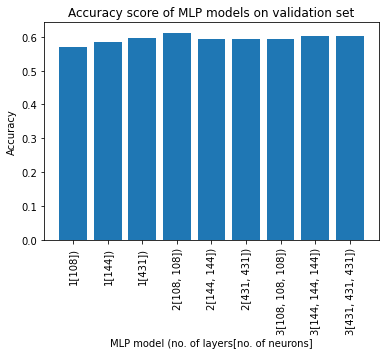

In [177]:
# Generate text displaying the amount of layers and neurons
ls_layer_v_neuron = [f'{len(layers_and_neurons[i])}{layers_and_neurons[i]})' for i in range(len(layers_and_neurons))]

plt.bar(ls_layer_v_neuron, accuracies)
plt.title("Accuracy score of MLP models on validation set")
plt.xlabel('MLP model (no. of layers[no. of neurons]')
plt.xticks(rotation = 90)
plt.ylabel('Accuracy')
plt.show()

Get the best model

In [178]:
max_index = accuracies.index(max(accuracies))
best_mlp = ls_mlps[max_index]
best_layer = list(layers_and_neurons[max_index])
print(f"Best MLP model w/ {len(best_layer)} hidden layers and {best_layer[0]} neurons each")
print("Accuracy (on validation set):", accuracies[max_index])

Best MLP model w/ 2 hidden layers and 108 neurons each
Accuracy (on validation set): 0.6122685185185185


Evaluate the accuracy of the best model on the test set

In [179]:
start_time = time.time()
best_mlp_score = best_mlp.score(x_test, y_test)
duration = time.time() - start_time
print("accuracy on test dataset =", best_mlp_score)
print("time taken to execute =", duration, 'seconds')

accuracy on test dataset = 0.6006944444444444
time taken to execute = 0.008000373840332031 seconds


Evaluate accuracy

Text(33.0, 0.5, 'Truth')

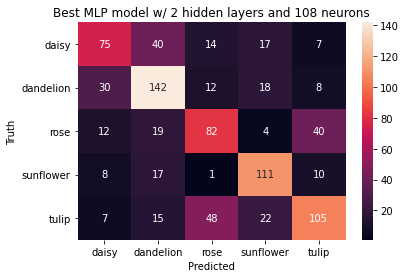

In [180]:
# Predict labels for confusion matrix
y_pred = mlp.predict(x_test)
# Get all unique labels from the test set
cm_labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred)

# Connect the confusion matrix indices with the proper text labels
cm_array_df = pd.DataFrame(cm, index=cm_labels, columns=cm_labels)

# Plot confusion matrix in a heatmap
sn.heatmap(cm_array_df, annot=True, fmt='d')
plt.title(f"Best MLP model w/ {len(best_layer)} hidden layers and {best_layer[0]} neurons")
plt.xlabel('Predicted')
plt.ylabel('Truth') 

Examples of correctly classified flowers

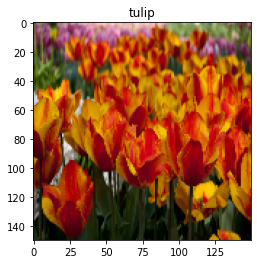

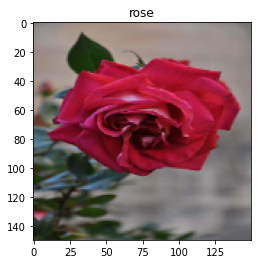

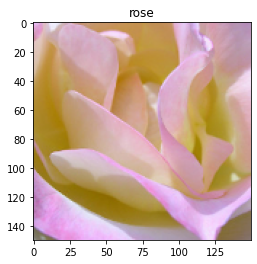

In [181]:
images_to_show = 3

# Find the indexes of the correctly classified flowers
indexes = []
for i, pred_flower in enumerate(y_pred):
        if pred_flower == y_test[i]:
            indexes.append(i)
            # Break out of loops if already found enough samples
            if len(indexes) >= images_to_show:
                break

for i in indexes:
    fig, ax1 = plt.subplots(1,1)
    ax1.set_title(y_test[i])
    ax1.imshow(cv2.cvtColor(x_image[test_label_indexes[i]], cv2.COLOR_BGR2RGB))
    plt.show()

Examples of wrongly classified flowers

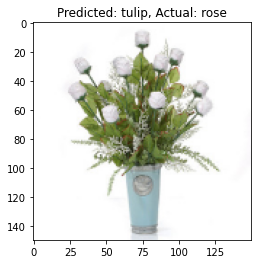

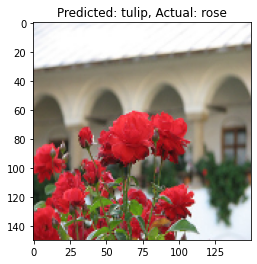

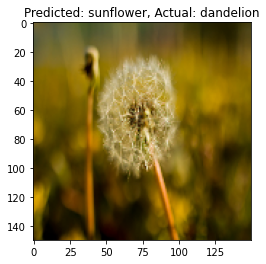

In [182]:
images_to_show = 3

# Find the indexes of the wrongly classified flowers
wrong_indexes = []
for i, pred_flower in enumerate(y_pred):
        if pred_flower != y_test[i]:
            wrong_indexes.append(i)
            # Break out of loops if already found enough samples
            if len(wrong_indexes) >= images_to_show:
                break

for i in wrong_indexes:
    fig, ax1 = plt.subplots(1,1)
    ax1.set_title(f'Predicted: {y_pred[i]}, Actual: {y_test[i]}')
    ax1.imshow(cv2.cvtColor(x_image[test_label_indexes[i]], cv2.COLOR_BGR2RGB))
    plt.show()